In [41]:
#Libraries that we'll use 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data_dir = 'C:/Users/user/Desktop/Machine Learning and Deep Learning/kaggle animal classifier/raw-img'

data = { 'imgpath':[], 'label':[] }

category = os.listdir(data_dir)

for folder in category:
    folderpath = os.path.join(data_dir,folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath,file)
        data['imgpath'].append(fpath)
        data['label'].append(folder)

In [155]:
print(data['imgpath'][0])
print(data['label'][0])

C:/Users/user/Desktop/Machine Learning and Deep Learning/kaggle animal classifier/raw-img\butterfly\e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg
butterfly


In [10]:
df = pd.DataFrame(data)
df.head()

,imgpath,label
0,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly
1,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly
2,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly
3,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly
4,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly


In [11]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['encoded_label'] = lb.fit_transform(df['label'])

In [16]:
df.sample(n=5,random_state=42)

,imgpath,label,encoded_label
1968,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly,0
17679,C:/Users/user/Desktop/Machine Learning and Dee...,sheep,7
5923,C:/Users/user/Desktop/Machine Learning and Dee...,chicken,2
1087,C:/Users/user/Desktop/Machine Learning and Dee...,butterfly,0
7172,C:/Users/user/Desktop/Machine Learning and Dee...,cow,3


In [17]:
df.shape

(26179, 3)

In [22]:
df.isnull().sum()

imgpath          0
label            0
encoded_label    0
dtype: int64

In [25]:
df.label.value_counts()

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: label, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split
train_df,Temp_df = train_test_split(
    df,
    train_size=0.80,
    shuffle=True,
    random_state=1
)
train_df.shape,Temp_df.shape

((20943, 3), (5236, 3))

In [36]:
validation_df,test_df=train_test_split(
    Temp_df,
    train_size=0.60,
    shuffle=True,
    random_state=1
)
validation_df.shape,test_df.shape

((3141, 3), (2095, 3))

In [37]:
train_df.head()

,imgpath,label,encoded_label
12190,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4
19440,C:/Users/user/Desktop/Machine Learning and Dee...,sheep,7
10065,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4
5816,C:/Users/user/Desktop/Machine Learning and Dee...,chicken,2
11425,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4


In [38]:
train_df = train_df.reset_index(drop=True)
train_df.head()
# look at the index part !!!

,imgpath,label,encoded_label
0,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4
1,C:/Users/user/Desktop/Machine Learning and Dee...,sheep,7
2,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4
3,C:/Users/user/Desktop/Machine Learning and Dee...,chicken,2
4,C:/Users/user/Desktop/Machine Learning and Dee...,dog,4


In [39]:
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

<function matplotlib.pyplot.show(close=None, block=None)>

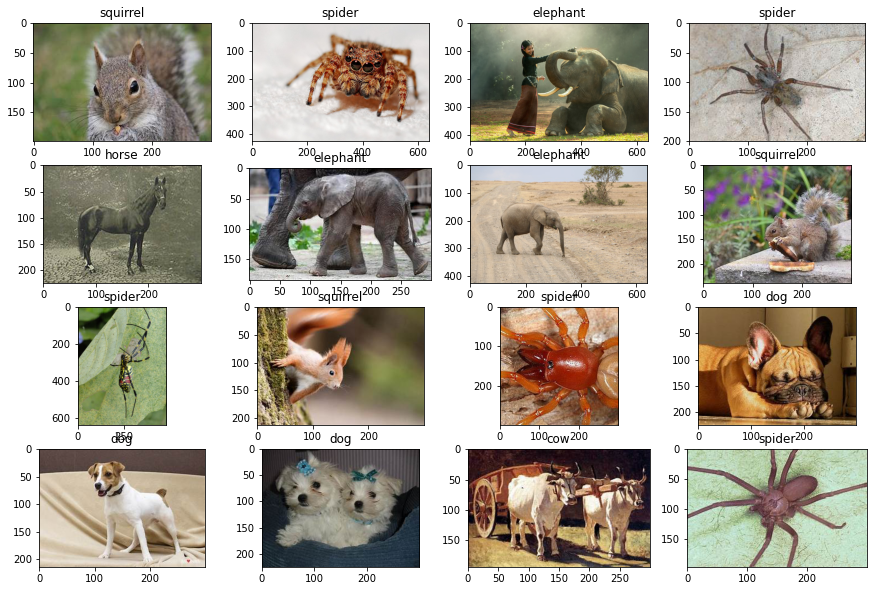

In [153]:
from PIL import Image
plt.figure(figsize=(15,10))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row['label'])
plt.show

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [79]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe= train_df, #instead of train_dir,
    x_col = 'imgpath',
    y_col = 'label',
    color_mode = 'rgb',
    target_size = (225,225),
    batch_size = 32,
    class_mode = 'categorical',
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'imgpath',
    y_col = 'label',
    color_mode = 'rgb',
    target_size = (225,225),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 20943 validated image filenames belonging to 10 classes.
Found 3141 validated image filenames belonging to 10 classes.


In [91]:
#callbacks

import time
import tensorflow as tf

checkPointCb = tf.keras.callbacks.ModelCheckpoint("./earlyStopModel.h5",save_best_only=True)
earlyStopingCb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)


class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [90]:
del model

In [92]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models,layers
from tensorflow import keras

model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu',strides=3,padding='valid', input_shape=(225,225,3)))
model.add(layers.MaxPooling2D((2,2)))
# now the size of img is 75
model.add(layers.Conv2D(64, (3,3), activation='relu',strides=2,padding='same'))
model.add(layers.MaxPooling2D((2,2)))
# now the size of img is 37
model.add(layers.Conv2D(128, (5,5), activation='relu',strides=1,padding='valid'))
model.add(layers.MaxPooling2D((2,2)))
# now the size of img is 18
model.add(layers.Conv2D(128, (3,3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2,2)))
# now the size of img is 9
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['acc']   
)


time_callback = TimeHistory()

history = model.fit(
    train_generator,
    steps_per_epoch = 654,
    epochs = 120,
    validation_data = validation_generator,
    validation_steps = 98,
    callbacks = [checkPointCb,earlyStopingCb,time_callback]
)

times = time_callback.times

print("Training times per epoch: ", times)
print("Total time: ", sum(times))

Epoch 1/120
654/654 [==============================] - 230s 351ms/step - loss: 2.1624 - acc: 0.2206 - val_loss: 1.9154 - val_acc: 0.3288
Epoch 2/120
654/654 [==============================] - 233s 356ms/step - loss: 1.8971 - acc: 0.3370 - val_loss: 1.6116 - val_acc: 0.4362
Epoch 3/120
654/654 [==============================] - 232s 354ms/step - loss: 1.6996 - acc: 0.4140 - val_loss: 1.4956 - val_acc: 0.4904
Epoch 4/120
654/654 [==============================] - 227s 346ms/step - loss: 1.5998 - acc: 0.4558 - val_loss: 1.4603 - val_acc: 0.4831
Epoch 5/120
654/654 [==============================] - 231s 354ms/step - loss: 1.5154 - acc: 0.4822 - val_loss: 1.2981 - val_acc: 0.5542
Epoch 6/120
654/654 [==============================] - 224s 343ms/step - loss: 1.4679 - acc: 0.5031 - val_loss: 1.2090 - val_acc: 0.5848
Epoch 7/120
654/654 [==============================] - 225s 343ms/step - loss: 1.4180 - acc: 0.5178 - val_loss: 1.2358 - val_acc: 0.5775
Epoch 8/120
654/654 [====================

In [158]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 74, 74, 32)        2432      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 9, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 5, 5, 128)         204928    
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 2, 2, 128)      

<function matplotlib.pyplot.show(close=None, block=None)>

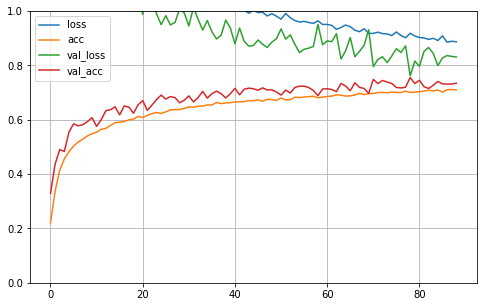

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [101]:
animals = [
    'butterfly',
    'cat',
    'chicken',
    'cow',
    'dog',
    'elephant',
    'horse',
    'sheep',
    'spider',
    'squirrel'
]
print(animals[0])

butterfly


1/1 [==============================] - 0s 71ms/step
[0.015 0.334 0.038 0.008 0.191 0.023 0.01  0.016 0.257 0.108]
It's a(n) cat for 33%


1/1 [==============================] - 0s 24ms/step
[0.    0.99  0.    0.    0.005 0.    0.    0.    0.004 0.   ]
It's a(n) cat for 99%


1/1 [==============================] - 0s 24ms/step
[0.    0.991 0.    0.    0.006 0.    0.    0.    0.002 0.   ]
It's a(n) cat for 99%


1/1 [==============================] - 0s 24ms/step
[0.014 0.401 0.018 0.004 0.216 0.008 0.007 0.01  0.073 0.249]
It's a(n) cat for 40%


1/1 [==============================] - 0s 28ms/step
[0.001 0.031 0.01  0.012 0.909 0.008 0.012 0.005 0.002 0.01 ]
It's a(n) dog for 90%


1/1 [==============================] - 0s 27ms/step
[0.001 0.491 0.002 0.001 0.484 0.    0.001 0.004 0.007 0.01 ]
It's a(n) cat for 49%


1/1 [==============================] - 0s 28ms/step
[0.001 0.049 0.003 0.001 0.94  0.    0.001 0.001 0.002 0.002]
It's a(n) dog for 93%


1/1 [=============================

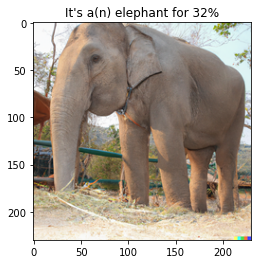

In [156]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
# Load the model
import numpy as np
from PIL import Image
%matplotlib inline

model = load_model('./earlyStopModel.h5')

paths = ['./cat.jpg','./cat2.png','./cat3.png','./cat5.png','./dog1.jpg','./dog2.jpg','./dog3.jpg','./horse.png','./horse2.png','./DALL.png']

for path in paths:
    img = load_img(path, target_size=(225, 225))
    x=img_to_array(img)
    x/=255
    x= np.expand_dims(x,axis=0)
    images = np.vstack([x])
    classes = model.predict(images)[0].round(3)
    print(classes)
    img  = Image.open(path)
    plt.imshow(img)
    plt.title("It's a(n) " + animals[classes.argmax()] +' for '+str(int(classes[classes.argmax()]*100)) +'%')
    plt.show
    print("It's a(n) " + animals[classes.argmax()] +' for '+str(int(classes[classes.argmax()]*100)) +'%')
    print('\n')
    
  
